In [ ]:
"""
(f) Shuffle dataset split dataset 70% training, 15% testing, 15% testing  
(e) 1.b Hyperpramaters that I found to be most beneficial for Endocer-Decoder
(g) 1.b2 Reverse string
(h) plots the chart of the validation accuracy for baseline and reversed datase

Model experimentation
2a. Choosing optimizers stick with Adam
2a.1 Tinkering adam optimizers choosing learning rate 0.0001
2a.2 adjusting betas for adam choosing betas1 0.99, and betas2 0.995
2a.3 adjusting batch sizes choosing batch sizes 64
2a.4 adjusting/adding dropouts picking values of 0.05
2a.5 adding activation to decoder choosing reLu
"""

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
# Alphabet and mapping from character to integer
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', ' ']
char_to_int = {c: i for i, c in enumerate(alphabet)}
num_chars = len(alphabet)

def one_hot(indices, num_classes):
    # Converts indices to one-hot encoded tensor
    return F.one_hot(indices, num_classes=num_classes)

def encode_string(string, length):
    # Encodes a string into a one-hot encoding with padding added at the end
    encoded = torch.tensor([char_to_int[char] for char in string])
    padding = torch.full((length - len(encoded),), num_chars-1)  # Padding with indexgenerated_queries of ' '
    padded_encoded = torch.cat((encoded, padding))
    return one_hot(padded_encoded, num_classes=num_chars).float()

# Generating and encoding data
generated_queries = []
generated_answers = []
for x in range(100):
    for y in range(100):
        generated_queries.append('{:02d}+{:02d}'.format(x, y))
        generated_queries.append('{:02d}-{:02d}'.format(x, y))
        generated_answers.append('{:+03d}'.format(x+y))
        generated_answers.append('{:+03d}'.format(x-y))

X = torch.stack([encode_string(q, 5) for q in generated_queries])
Y = torch.stack([encode_string(a, 4) for a in generated_answers])


In [20]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print(generated_queries[11297])
print(X[11297])

X shape: torch.Size([20000, 5, 13])
Y shape: torch.Size([20000, 4, 13])
56-48
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


## Shuffle dataset

In [21]:
# Prepare data for DataLoader
dataset = TensorDataset(X, Y)
test_dataset = TensorDataset(X, Y)

# split dataset 70% training, 15% testing, 15% testing  
subtrain_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
train_dataset, val_dataset, test_dataset = random_split(dataset, [subtrain_size, val_size, (len(dataset) - subtrain_size - val_size)])

print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
print(num_chars)

20000
14000
3000
3000
13


## 1a. Baseline (default) model

In [299]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)

    def forward(self, x):
        _, (hidden, cell) = self.rnn(x)
        return hidden, cell
        # ensure x shape accroddinly 

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

In [12]:
# hyperpramaters config
# constraint values
hidden_size = 128
num_layers = 2
num_chars
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.1).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source
        # batchsize x5x13
        # target
        # batchsize x4x13
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_token_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, target_len, target_token_size).to(device)
        hidden, cell = self.encoder(source)
        # 64x13
        input = target[:, 0, :]
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t-1, :] = output  # Adjusted indexing
            teacher_force = random.random() < teacher_forcing_ratio
            input = target[:, t, :] if teacher_force else output
        
        return outputs
        
        
         

In [32]:

# Training Loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for data, targets in loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(data, targets)
        outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])

        # Check if targets are one-hot and convert if necessary
        if targets.dim() == 3:  # Assuming one-hot encoded targets
            targets = torch.argmax(targets, dim=2) # Convert one-hot to indices
        targets = targets[:, 1:].reshape(-1) # Flatten targets to match outputs

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Backward and optimizer
        loss.backward()
        optimizer.step()

        
        # Calculate accuracy
        _, predicted = torch.max(outputs, dim=1)  # Get the indices of the max log-probability
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        
    training_loss = total_loss / len(loader)
    training_accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return training_loss, training_accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data, targets)  # Assuming no teacher forcing during evaluation
            outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])  # Flatten outputs

            # Check if targets are one-hot and convert if necessary
            if targets.dim() == 3:  # Assuming one-hot encoded targets
                targets = torch.argmax(targets, dim=2)  # Convert one-hot to indices
            targets = targets[:, 1:].reshape(-1)  # Flatten targets to match outputs

            # print("Flattened outputs shape:", outputs.shape)  # Debug
            # print("Flattened targets shape:", targets.shape)  # Debug

            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_predictions += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

    validation_loss = total_loss / len(loader)
    validation_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return validation_loss, validation_accuracy

    

In [303]:
def plot_model(tr_acc, tr_loss, val_acc, val_loss):
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [1]:

def train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch, p=0):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # Epochs
    tr_acc, tr_loss = [], []
    
    val_acc, val_loss = [], []
    for epoch in range(num_epochs):
        training_loss, training_accuracy = train(model, train_loader, optimizer, criterion, device)
        tr_acc.append(training_accuracy)
        tr_loss.append(training_loss)
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {1 + epoch}/{num_epochs}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.4f}')
    
        validation_loss, validation_accuracy = evaluate(model, val_loader, criterion, device)
        val_acc.append(validation_accuracy)
        val_loss.append(validation_loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {1 + epoch}/{num_epochs}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')
    
    
    # Testing Loop - Similar to validation loop but with the test_loader
    test_loss, validation_accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")
    return tr_acc, tr_loss, val_acc, val_loss 

In [612]:
#f Plot
def plot(val_acc, val_acc_rev=[]):
    plt.figure(figsize=(10, 5))
    plt.plot(val_acc, label='Baseline Validation Accuracy')
    plt.plot(val_acc_rev, label='Reversed Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Epochs')
    plt.legend()
    plt.show()


# 1.b Best model hyperparameters

In [8]:
"""
batch = 64, num_epochs = 100, lr = 0.001, dropout = 0.05, activation reLu
optimizer choosen ADAM
betas1 = 0.99, betas2= 0.995
"""

'\nbatch = 64, num_epochs = 100, lr = 0.001, dropout = 0.05, activation reLu\noptimizer choosen ADAM\nbetas1 = 0.99, betas2= 0.995\n'

In [29]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) 
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [33]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)

    def forward(self, x):
        _, (hidden, cell) = self.rnn(x)
        return hidden, cell
   

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)  # create a dropout layer
        self.relu = nn.ReLU() # added activation relu function in Decoder


    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        output = self.dropout(output)  # Apply dropout
        prediction = self.relu(self.fc(output.squeeze(1)))
        return prediction, hidden, cell

In [561]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2870, Training Accuracy: 0.5052
Epoch 10/100, Validation Loss: 1.2134, Validation Accuracy: 0.5261
Epoch 20/100, Training Loss: 1.1686, Training Accuracy: 0.5498
Epoch 20/100, Validation Loss: 1.1566, Validation Accuracy: 0.5449
Epoch 30/100, Training Loss: 0.9528, Training Accuracy: 0.6328
Epoch 30/100, Validation Loss: 0.9307, Validation Accuracy: 0.6481
Epoch 40/100, Training Loss: 0.9026, Training Accuracy: 0.6512
Epoch 40/100, Validation Loss: 0.8906, Validation Accuracy: 0.6561
Epoch 50/100, Training Loss: 0.8767, Training Accuracy: 0.6601
Epoch 50/100, Validation Loss: 0.8684, Validation Accuracy: 0.6634
Epoch 60/100, Training Loss: 0.8733, Training Accuracy: 0.6610
Epoch 60/100, Validation Loss: 0.9101, Validation Accuracy: 0.6474
Epoch 70/100, Training Loss: 0.8643, Training Accuracy: 0.6637
Epoch 70/100, Validation Loss: 0.8586, Validation Accuracy: 0.6660
Epoch 80/100, Training Loss: 0.8632, Training Accuracy: 0.6644
Epoch 80/100, Validation Lo

In [557]:
baseline_val_acc = val_acc

## 1b.2 Reverse strings queary and answer and retain model, and same hyperparameters

In [5]:
# Alphabet and mapping from character to integer
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', ' ']
char_to_int = {c: i for i, c in enumerate(alphabet)}
num_chars = len(alphabet)

def one_hot(indices, num_classes):
    # Converts indices to one-hot encoded tensor
    return F.one_hot(indices, num_classes=num_classes)

def encode_string(string, length):
    # Encodes a string into a one-hot encoding with padding added at the end
    encoded = torch.tensor([char_to_int[char] for char in string])
    padding = torch.full((length - len(encoded),), num_chars-1)  # Padding with indexgenerated_queries of ' '
    padded_encoded = torch.cat((encoded, padding))
    return one_hot(padded_encoded, num_classes=num_chars).float()

# Generating and encoding data
generated_queries = []
generated_answers = []

        

for x in range(100):
    for y in range(100):
        temp = '{:02d}+{:02d}'.format(x, y)
        generated_queries.append(temp[::-1])
        temp = '{:02d}-{:02d}'.format(x, y)
        generated_queries.append(temp[::-1])
        temp = '{:+03d}'.format(x+y)
        generated_answers.append(temp[::-1])
        temp = '{:+03d}'.format(x-y)
        generated_answers.append(temp[::-1])

        
X = torch.stack([encode_string(q, 5) for q in generated_queries])
Y = torch.stack([encode_string(a, 4) for a in generated_answers])


In [7]:
print(generated_queries[11297])
print(generated_answers[11297])
print(X[11297])

84-65
80+
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


In [608]:
# Prepare data for DataLoader
dataset = TensorDataset(X, Y)
test_dataset = TensorDataset(X, Y)

# split dataset 70% training, 15% testing, 15% testing  
subtrain_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
train_dataset, val_dataset, test_dataset = random_split(dataset, [subtrain_size, val_size, (len(dataset) - subtrain_size - val_size)])

In [609]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) 
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [610]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.0293, Training Accuracy: 0.5975
Epoch 10/100, Validation Loss: 1.0179, Validation Accuracy: 0.5880
Epoch 20/100, Training Loss: 0.8786, Training Accuracy: 0.6605
Epoch 20/100, Validation Loss: 0.8671, Validation Accuracy: 0.6652
Epoch 30/100, Training Loss: 0.9013, Training Accuracy: 0.6499
Epoch 30/100, Validation Loss: 0.8846, Validation Accuracy: 0.6558
Epoch 40/100, Training Loss: 0.8719, Training Accuracy: 0.6609
Epoch 40/100, Validation Loss: 0.8577, Validation Accuracy: 0.6663
Epoch 50/100, Training Loss: 0.8598, Training Accuracy: 0.6655
Epoch 50/100, Validation Loss: 0.8577, Validation Accuracy: 0.6657
Epoch 60/100, Training Loss: 0.8606, Training Accuracy: 0.6650
Epoch 60/100, Validation Loss: 0.8580, Validation Accuracy: 0.6659
Epoch 70/100, Training Loss: 0.8619, Training Accuracy: 0.6645
Epoch 70/100, Validation Loss: 0.8642, Validation Accuracy: 0.6640
Epoch 80/100, Training Loss: 0.8734, Training Accuracy: 0.6600
Epoch 80/100, Validation Lo

## 1b.3 chart validation accuracy

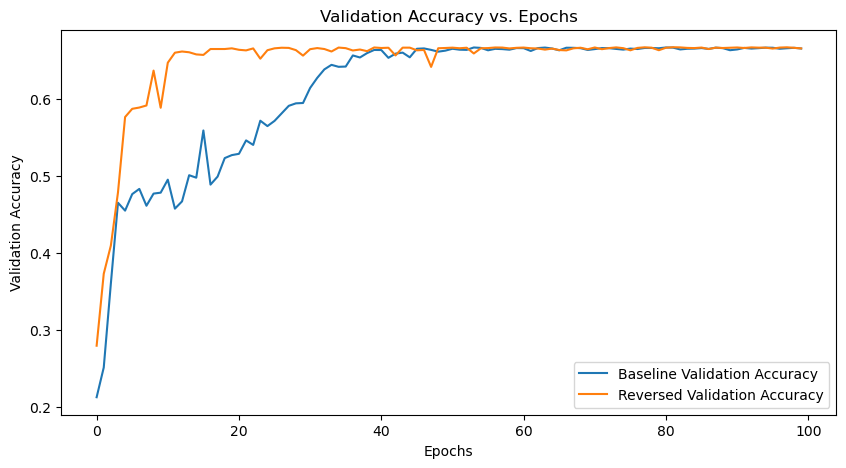

In [613]:
plot(baseline_val_acc, val_acc)

## 2a. Model Experimentation hyperparameters: Testing out different optimizers

In [543]:
# Uses the baseline model from above not best model

In [149]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.01
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [145]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2111, Training Accuracy: 0.5370
Epoch 10/100, Validation Loss: 1.6076, Validation Accuracy: 0.3832
Epoch 20/100, Training Loss: 1.1722, Training Accuracy: 0.5536
Epoch 20/100, Validation Loss: 1.4996, Validation Accuracy: 0.4280
Epoch 30/100, Training Loss: 1.0025, Training Accuracy: 0.6150
Epoch 30/100, Validation Loss: 1.2420, Validation Accuracy: 0.5401
Epoch 40/100, Training Loss: 0.9038, Training Accuracy: 0.6589
Epoch 40/100, Validation Loss: 0.9356, Validation Accuracy: 0.6508
Epoch 50/100, Training Loss: 0.8810, Training Accuracy: 0.6674
Epoch 50/100, Validation Loss: 0.9133, Validation Accuracy: 0.6613
Epoch 60/100, Training Loss: 0.8896, Training Accuracy: 0.6651
Epoch 60/100, Validation Loss: 0.8909, Validation Accuracy: 0.6669
Epoch 70/100, Training Loss: 0.8767, Training Accuracy: 0.6684
Epoch 70/100, Validation Loss: 0.9010, Validation Accuracy: 0.6647
Epoch 80/100, Training Loss: 0.8783, Training Accuracy: 0.6677
Epoch 80/100, Validation Lo

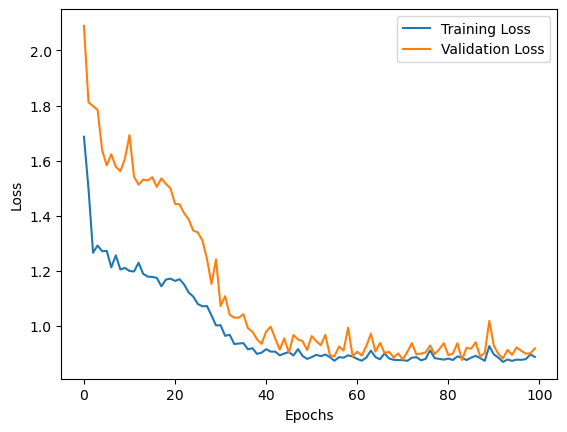

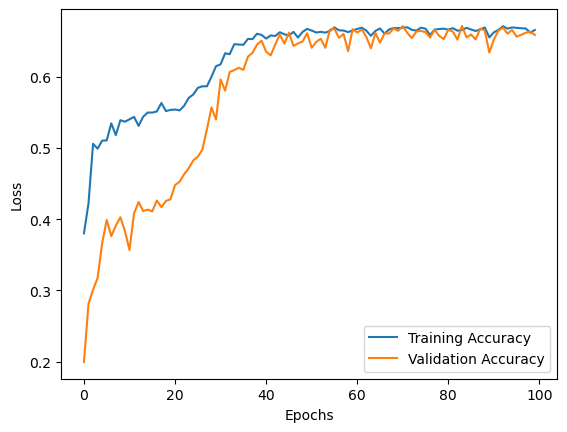

In [146]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
"""
Adam showing promising results as balance between training loss and validation loss appear to be somewhat stable.
Additionally, the accuracy and loss seem to plateau close together. 
"""

In [ ]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

In [167]:
# DataLoader
batch_size = 64
epoch = 100
#learning_rate = 0.01
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.1).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.SGD(model.parameters())
criterion = nn.CrossEntropyLoss()


In [168]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 2.5276, Training Accuracy: 0.1610
Epoch 10/100, Validation Loss: 2.5226, Validation Accuracy: 0.1712
Epoch 20/100, Training Loss: 2.4917, Training Accuracy: 0.1610
Epoch 20/100, Validation Loss: 2.4854, Validation Accuracy: 0.1712
Epoch 30/100, Training Loss: 2.4651, Training Accuracy: 0.1610
Epoch 30/100, Validation Loss: 2.4576, Validation Accuracy: 0.1712
Epoch 40/100, Training Loss: 2.4454, Training Accuracy: 0.1610
Epoch 40/100, Validation Loss: 2.4370, Validation Accuracy: 0.1712
Epoch 50/100, Training Loss: 2.4309, Training Accuracy: 0.1610
Epoch 50/100, Validation Loss: 2.4218, Validation Accuracy: 0.1712
Epoch 60/100, Training Loss: 2.4197, Training Accuracy: 0.1610
Epoch 60/100, Validation Loss: 2.4101, Validation Accuracy: 0.1712
Epoch 70/100, Training Loss: 2.4110, Training Accuracy: 0.1610
Epoch 70/100, Validation Loss: 2.4009, Validation Accuracy: 0.1712
Epoch 80/100, Training Loss: 2.4038, Training Accuracy: 0.1610
Epoch 80/100, Validation Lo

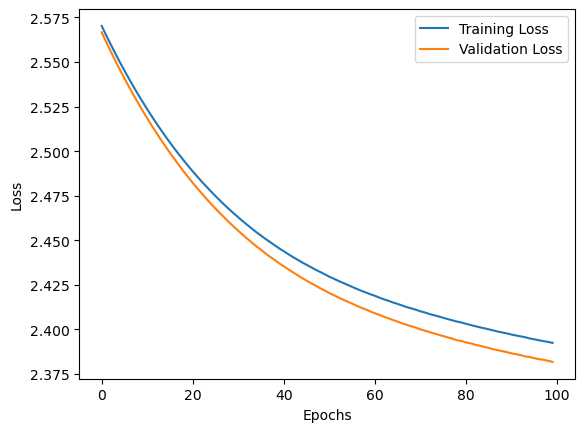

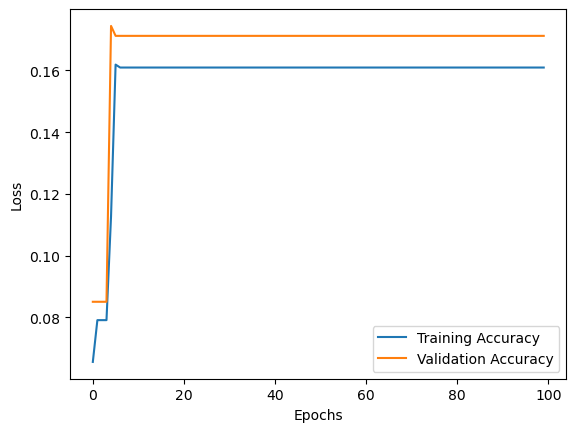

In [169]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
"""
SDG optimizer compare to pervious one shows a smooth between training and valiadtion may be worth while to do more addjustments
on the hyperpramater.
"""

In [161]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.01
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.1).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [162]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3298, Training Accuracy: 0.4921
Epoch 10/100, Validation Loss: 1.3523, Validation Accuracy: 0.4748
Epoch 20/100, Training Loss: 1.2994, Training Accuracy: 0.5081
Epoch 20/100, Validation Loss: 1.1292, Validation Accuracy: 0.5827
Epoch 30/100, Training Loss: 1.2285, Training Accuracy: 0.5362
Epoch 30/100, Validation Loss: 1.2534, Validation Accuracy: 0.5326
Epoch 40/100, Training Loss: 1.2034, Training Accuracy: 0.5445
Epoch 40/100, Validation Loss: 1.2183, Validation Accuracy: 0.5460
Epoch 50/100, Training Loss: 1.1832, Training Accuracy: 0.5541
Epoch 50/100, Validation Loss: 1.2003, Validation Accuracy: 0.5517
Epoch 60/100, Training Loss: 1.2183, Training Accuracy: 0.5410
Epoch 60/100, Validation Loss: 1.1405, Validation Accuracy: 0.5726
Epoch 70/100, Training Loss: 1.1891, Training Accuracy: 0.5519
Epoch 70/100, Validation Loss: 1.1426, Validation Accuracy: 0.5766
Epoch 80/100, Training Loss: 1.1552, Training Accuracy: 0.5636
Epoch 80/100, Validation Lo

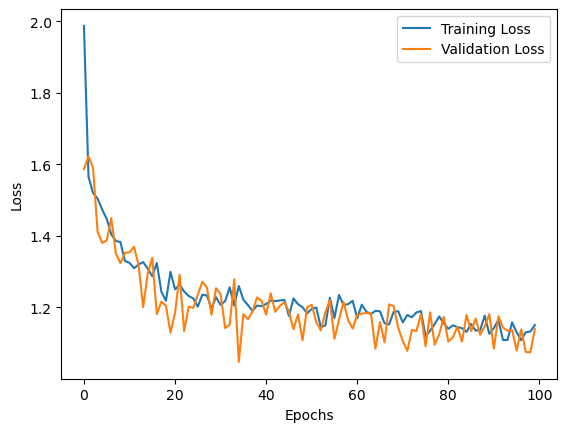

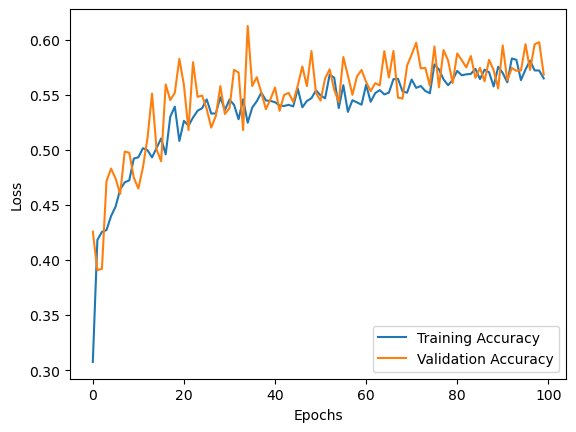

In [163]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

"""
Adagrad optimizer compare to adam the accuracy for traning and validation appears to be lower as it plateau around .65. Nonetheless, the epochs show
it is stable with learning throughout the training process 
"""

In [164]:
# DataLoader
batch_size = 64
num_epochs = 100
#learning_rate = 0.01
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.1).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

In [165]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2565, Training Accuracy: 0.5183
Epoch 10/100, Validation Loss: 1.2609, Validation Accuracy: 0.5170
Epoch 20/100, Training Loss: 1.1659, Training Accuracy: 0.5555
Epoch 20/100, Validation Loss: 1.2279, Validation Accuracy: 0.5339
Epoch 30/100, Training Loss: 1.1105, Training Accuracy: 0.5720
Epoch 30/100, Validation Loss: 1.1606, Validation Accuracy: 0.5553
Epoch 40/100, Training Loss: 0.9306, Training Accuracy: 0.6470
Epoch 40/100, Validation Loss: 0.9208, Validation Accuracy: 0.6536
Epoch 50/100, Training Loss: 0.8930, Training Accuracy: 0.6624
Epoch 50/100, Validation Loss: 0.9004, Validation Accuracy: 0.6644
Epoch 60/100, Training Loss: 0.8893, Training Accuracy: 0.6646
Epoch 60/100, Validation Loss: 0.9005, Validation Accuracy: 0.6621
Epoch 70/100, Training Loss: 0.8835, Training Accuracy: 0.6671
Epoch 70/100, Validation Loss: 0.8748, Validation Accuracy: 0.6720
Epoch 80/100, Training Loss: 0.8749, Training Accuracy: 0.6695
Epoch 80/100, Validation Lo

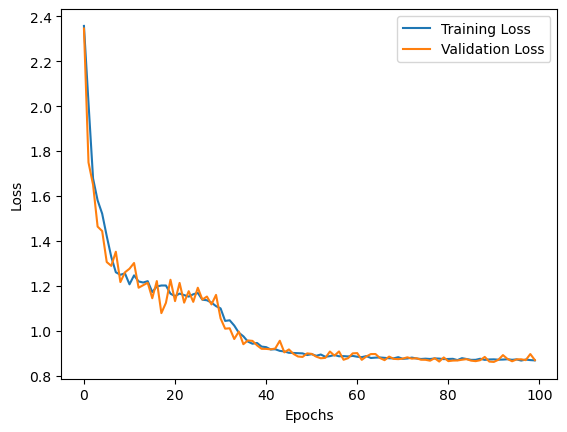

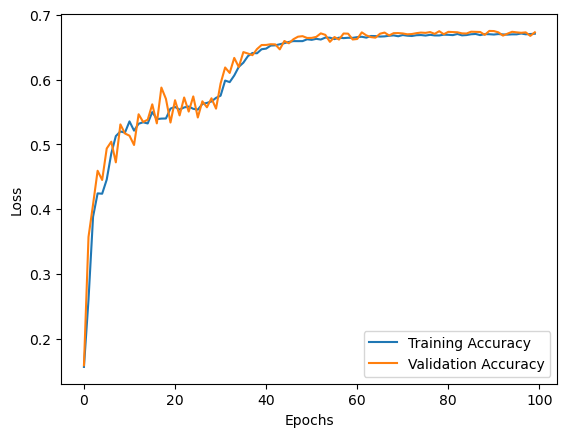

In [166]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
"""
RMSprop optimizer compare perfomrance for training and validaition loss seem stable but adam appears better improvments to 
near ends of accureacy and loss
"""

## 2a.1 Model Experimentation hyperparameters: Further testing on Adam

In [ ]:
# sticking with adam optimizer as the smooth and consistent performance of Adam in both the training and validation 
# begining testing on the lr

In [173]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 # adjust hyperpramater 0.01 -> 0.001
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [174]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2703, Training Accuracy: 0.5144
Epoch 10/100, Validation Loss: 1.2859, Validation Accuracy: 0.5099
Epoch 20/100, Training Loss: 1.1296, Training Accuracy: 0.5706
Epoch 20/100, Validation Loss: 1.1828, Validation Accuracy: 0.5508
Epoch 30/100, Training Loss: 0.9277, Training Accuracy: 0.6547
Epoch 30/100, Validation Loss: 0.9157, Validation Accuracy: 0.6568
Epoch 40/100, Training Loss: 0.8919, Training Accuracy: 0.6634
Epoch 40/100, Validation Loss: 0.9573, Validation Accuracy: 0.6447
Epoch 50/100, Training Loss: 0.9063, Training Accuracy: 0.6599
Epoch 50/100, Validation Loss: 0.9677, Validation Accuracy: 0.6376
Epoch 60/100, Training Loss: 0.8753, Training Accuracy: 0.6701
Epoch 60/100, Validation Loss: 0.9072, Validation Accuracy: 0.6609
Epoch 70/100, Training Loss: 0.8904, Training Accuracy: 0.6640
Epoch 70/100, Validation Loss: 0.8732, Validation Accuracy: 0.6726
Epoch 80/100, Training Loss: 0.8587, Training Accuracy: 0.6749
Epoch 80/100, Validation Lo

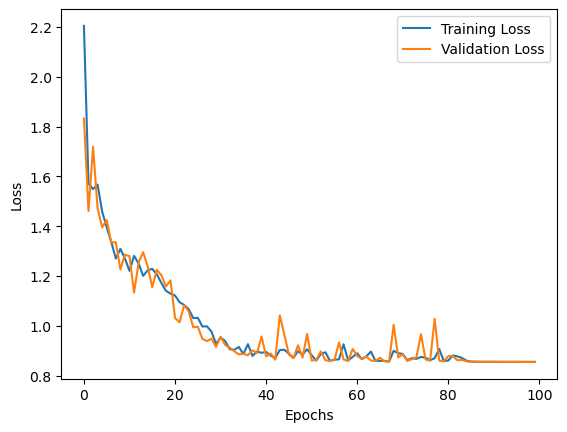

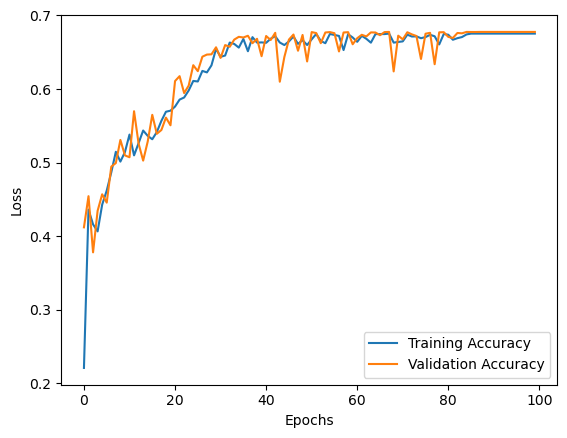

In [175]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [176]:
# smoother decline in both training and validation losses, suggesting better stability keep changes lr

In [177]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.0009 # adjust hyperpramater 0.001->0.0009
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [179]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3545, Training Accuracy: 0.4819
Epoch 10/100, Validation Loss: 1.3709, Validation Accuracy: 0.4653
Epoch 20/100, Training Loss: 1.2026, Training Accuracy: 0.5458
Epoch 20/100, Validation Loss: 1.1189, Validation Accuracy: 0.5789
Epoch 30/100, Training Loss: 1.1325, Training Accuracy: 0.5737
Epoch 30/100, Validation Loss: 1.0927, Validation Accuracy: 0.5887
Epoch 40/100, Training Loss: 0.9446, Training Accuracy: 0.6455
Epoch 40/100, Validation Loss: 0.9864, Validation Accuracy: 0.6262
Epoch 50/100, Training Loss: 0.8975, Training Accuracy: 0.6613
Epoch 50/100, Validation Loss: 0.8845, Validation Accuracy: 0.6707
Epoch 60/100, Training Loss: 0.9756, Training Accuracy: 0.6417
Epoch 60/100, Validation Loss: 0.8832, Validation Accuracy: 0.6731
Epoch 70/100, Training Loss: 0.8580, Training Accuracy: 0.6754
Epoch 70/100, Validation Loss: 0.8578, Validation Accuracy: 0.6777
Epoch 80/100, Training Loss: 0.8763, Training Accuracy: 0.6697
Epoch 80/100, Validation Lo

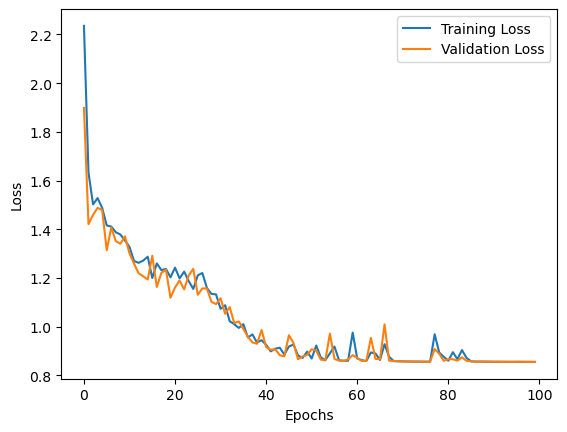

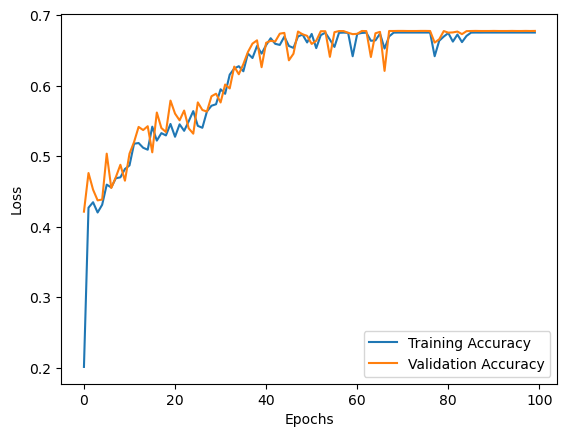

In [180]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [181]:
# DataLoader
batch_size = 64
num_epochs = 100
learning_rate = 0.0007 # adjust hyperpramater 0.0009->0.0007
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Testing out the increase range to see if any difference is made

In [182]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3239, Training Accuracy: 0.4937
Epoch 10/100, Validation Loss: 1.3171, Validation Accuracy: 0.5084
Epoch 20/100, Training Loss: 1.2184, Training Accuracy: 0.5359
Epoch 20/100, Validation Loss: 1.1733, Validation Accuracy: 0.5541
Epoch 30/100, Training Loss: 1.1779, Training Accuracy: 0.5530
Epoch 30/100, Validation Loss: 1.1349, Validation Accuracy: 0.5663
Epoch 40/100, Training Loss: 1.1235, Training Accuracy: 0.5709
Epoch 40/100, Validation Loss: 1.0674, Validation Accuracy: 0.5976
Epoch 50/100, Training Loss: 1.0225, Training Accuracy: 0.6130
Epoch 50/100, Validation Loss: 0.9761, Validation Accuracy: 0.6326
Epoch 60/100, Training Loss: 0.9257, Training Accuracy: 0.6544
Epoch 60/100, Validation Loss: 0.9521, Validation Accuracy: 0.6412
Epoch 70/100, Training Loss: 0.9130, Training Accuracy: 0.6559
Epoch 70/100, Validation Loss: 0.8860, Validation Accuracy: 0.6720
Epoch 80/100, Training Loss: 0.8781, Training Accuracy: 0.6694
Epoch 80/100, Validation Lo

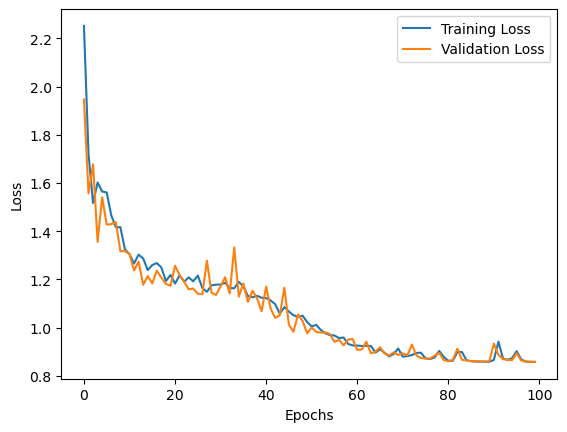

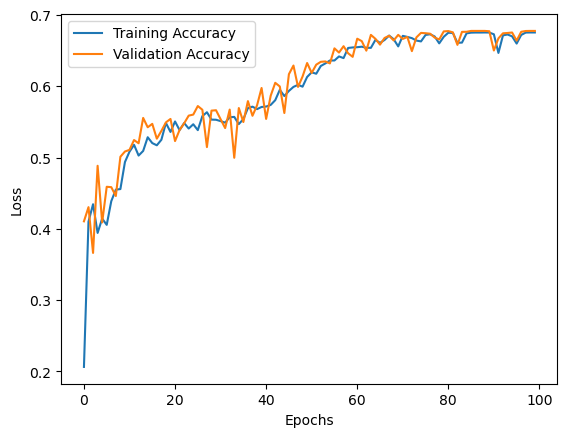

In [183]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [184]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.002 # adjust hyperpramater 0.001 -> 0.002
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [186]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2274, Training Accuracy: 0.5317
Epoch 10/100, Validation Loss: 1.2196, Validation Accuracy: 0.5346
Epoch 20/100, Training Loss: 0.9511, Training Accuracy: 0.6413
Epoch 20/100, Validation Loss: 0.9132, Validation Accuracy: 0.6588
Epoch 30/100, Training Loss: 0.8780, Training Accuracy: 0.6682
Epoch 30/100, Validation Loss: 0.8682, Validation Accuracy: 0.6741
Epoch 40/100, Training Loss: 0.8812, Training Accuracy: 0.6670
Epoch 40/100, Validation Loss: 0.8832, Validation Accuracy: 0.6691
Epoch 50/100, Training Loss: 0.8626, Training Accuracy: 0.6736
Epoch 50/100, Validation Loss: 0.8667, Validation Accuracy: 0.6740
Epoch 60/100, Training Loss: 0.9238, Training Accuracy: 0.6557
Epoch 60/100, Validation Loss: 0.8618, Validation Accuracy: 0.6768
Epoch 70/100, Training Loss: 0.8688, Training Accuracy: 0.6714
Epoch 70/100, Validation Loss: 0.8590, Validation Accuracy: 0.6766
Epoch 80/100, Training Loss: 0.8710, Training Accuracy: 0.6712
Epoch 80/100, Validation Lo

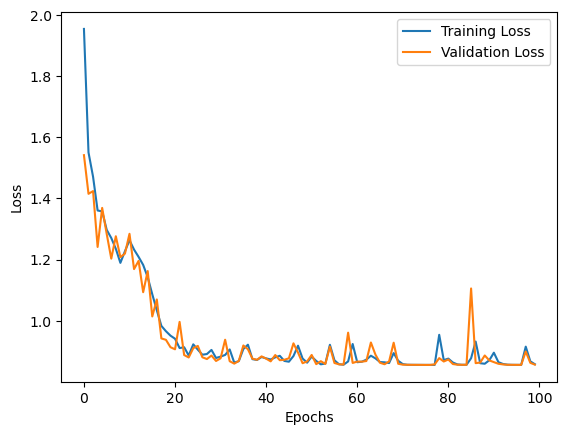

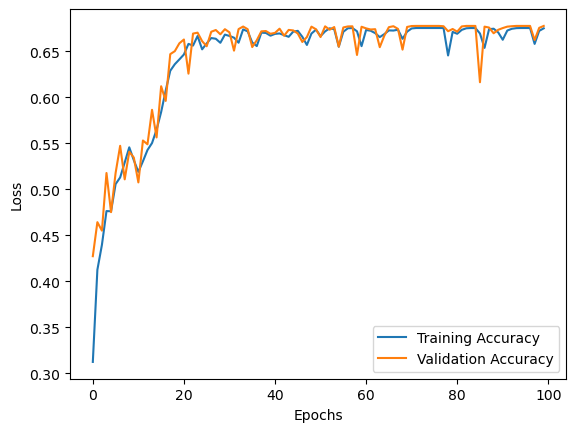

In [187]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [189]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.005 # adjust hyperpramater 0.002 -> 0.005
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [190]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2654, Training Accuracy: 0.5155
Epoch 10/100, Validation Loss: 1.2352, Validation Accuracy: 0.5314
Epoch 20/100, Training Loss: 1.0541, Training Accuracy: 0.5975
Epoch 20/100, Validation Loss: 1.0428, Validation Accuracy: 0.6031
Epoch 30/100, Training Loss: 0.8982, Training Accuracy: 0.6605
Epoch 30/100, Validation Loss: 0.8819, Validation Accuracy: 0.6683
Epoch 40/100, Training Loss: 0.8878, Training Accuracy: 0.6646
Epoch 40/100, Validation Loss: 0.8660, Validation Accuracy: 0.6743
Epoch 50/100, Training Loss: 0.8687, Training Accuracy: 0.6712
Epoch 50/100, Validation Loss: 0.8594, Validation Accuracy: 0.6764
Epoch 60/100, Training Loss: 0.8669, Training Accuracy: 0.6718
Epoch 60/100, Validation Loss: 0.8706, Validation Accuracy: 0.6726
Epoch 70/100, Training Loss: 0.8622, Training Accuracy: 0.6735
Epoch 70/100, Validation Loss: 0.8746, Validation Accuracy: 0.6707
Epoch 80/100, Training Loss: 0.8555, Training Accuracy: 0.6754
Epoch 80/100, Validation Lo

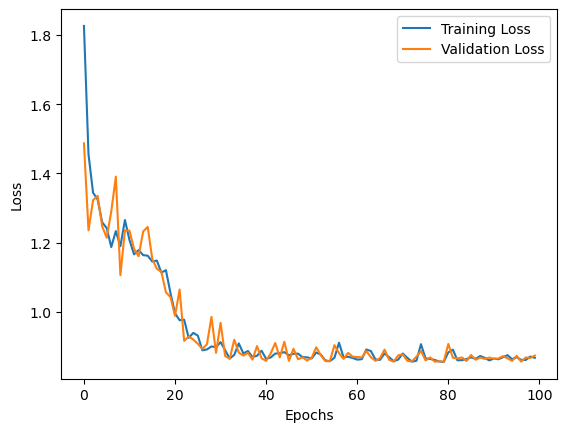

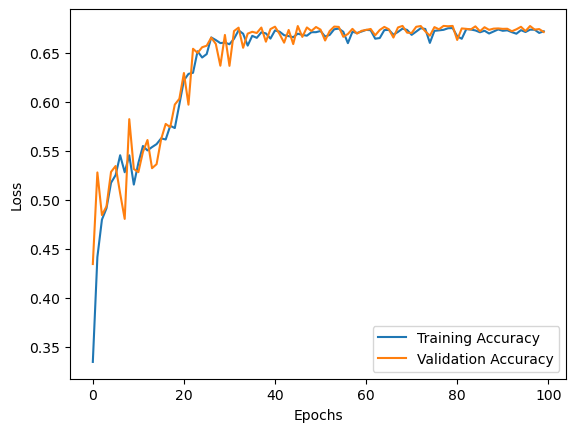

In [191]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [195]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.009 # adjust hyperpramater 0.002 -> 0.005
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [196]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.1811, Training Accuracy: 0.5462
Epoch 10/100, Validation Loss: 1.1966, Validation Accuracy: 0.5440
Epoch 20/100, Training Loss: 1.1373, Training Accuracy: 0.5644
Epoch 20/100, Validation Loss: 1.0566, Validation Accuracy: 0.5972
Epoch 30/100, Training Loss: 0.9528, Training Accuracy: 0.6398
Epoch 30/100, Validation Loss: 0.9503, Validation Accuracy: 0.6448
Epoch 40/100, Training Loss: 0.8910, Training Accuracy: 0.6639
Epoch 40/100, Validation Loss: 0.8692, Validation Accuracy: 0.6728
Epoch 50/100, Training Loss: 0.8645, Training Accuracy: 0.6726
Epoch 50/100, Validation Loss: 0.8603, Validation Accuracy: 0.6767
Epoch 60/100, Training Loss: 0.8625, Training Accuracy: 0.6735
Epoch 60/100, Validation Loss: 0.8631, Validation Accuracy: 0.6751
Epoch 70/100, Training Loss: 0.8684, Training Accuracy: 0.6717
Epoch 70/100, Validation Loss: 0.8603, Validation Accuracy: 0.6763
Epoch 80/100, Training Loss: 0.8630, Training Accuracy: 0.6729
Epoch 80/100, Validation Lo

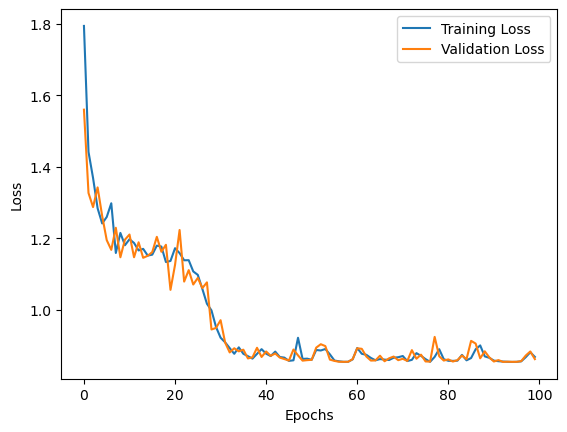

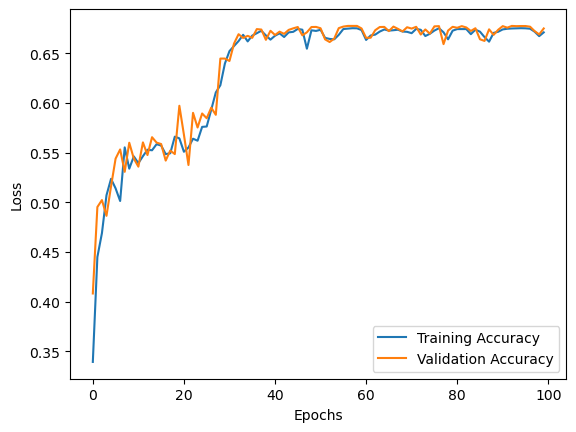

In [197]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [547]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)

    def forward(self, x):
        _, (hidden, cell) = self.rnn(x)
        return hidden, cell
   

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)  # create a dropout layer
        self.relu = nn.ReLU() # added activation relu function in Decoder


    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        output = self.dropout(output)  # Apply dropout
        prediction = self.relu(self.fc(output.squeeze(1)))
        return prediction, hidden, cell

In [ ]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) 
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [198]:
# Adjustments to the finer adjustments around lr 0.001 seem to be minimal so I'll stick with the lr 0.0001

# 2a.2 Model Experimentation hyperparameters: Adjust beta values

### beta1

In [200]:
# DataLoader
batch_size = 64
num_epochs = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.85,0.999)) # adjust hyperpramater 0.90 -> 0.85
criterion = nn.CrossEntropyLoss()


In [201]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2959, Training Accuracy: 0.5051
Epoch 10/100, Validation Loss: 1.2985, Validation Accuracy: 0.5102
Epoch 20/100, Training Loss: 1.2010, Training Accuracy: 0.5452
Epoch 20/100, Validation Loss: 1.1829, Validation Accuracy: 0.5547
Epoch 30/100, Training Loss: 0.9609, Training Accuracy: 0.6399
Epoch 30/100, Validation Loss: 0.9607, Validation Accuracy: 0.6383
Epoch 40/100, Training Loss: 0.9139, Training Accuracy: 0.6557
Epoch 40/100, Validation Loss: 0.8970, Validation Accuracy: 0.6624
Epoch 50/100, Training Loss: 0.8666, Training Accuracy: 0.6726
Epoch 50/100, Validation Loss: 0.8834, Validation Accuracy: 0.6692
Epoch 60/100, Training Loss: 0.8843, Training Accuracy: 0.6665
Epoch 60/100, Validation Loss: 0.8635, Validation Accuracy: 0.6762
Epoch 70/100, Training Loss: 0.8565, Training Accuracy: 0.6754
Epoch 70/100, Validation Loss: 0.8565, Validation Accuracy: 0.6777
Epoch 80/100, Training Loss: 0.8563, Training Accuracy: 0.6754
Epoch 80/100, Validation Lo

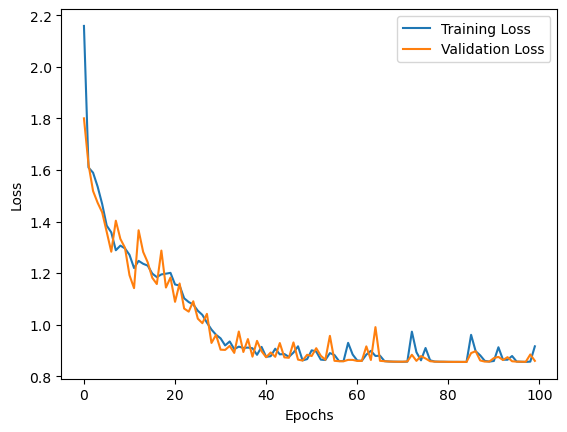

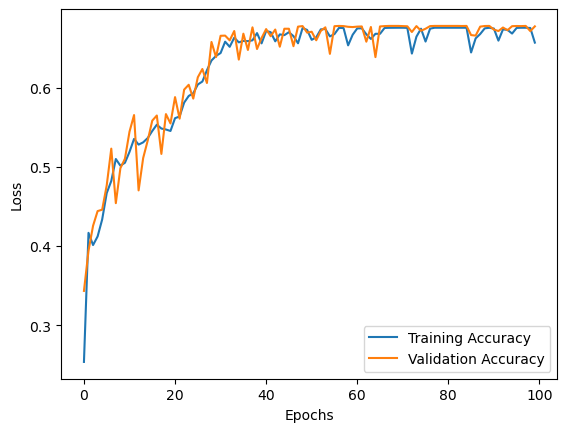

In [202]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [203]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.95,0.999)) # adjust hyperpramater 0.90 -> 0.95
criterion = nn.CrossEntropyLoss()


In [204]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3531, Training Accuracy: 0.4801
Epoch 10/100, Validation Loss: 1.3714, Validation Accuracy: 0.4659
Epoch 20/100, Training Loss: 1.1391, Training Accuracy: 0.5700
Epoch 20/100, Validation Loss: 1.1625, Validation Accuracy: 0.5603
Epoch 30/100, Training Loss: 0.9794, Training Accuracy: 0.6298
Epoch 30/100, Validation Loss: 0.9616, Validation Accuracy: 0.6388
Epoch 40/100, Training Loss: 0.9063, Training Accuracy: 0.6588
Epoch 40/100, Validation Loss: 0.9103, Validation Accuracy: 0.6591
Epoch 50/100, Training Loss: 0.8762, Training Accuracy: 0.6697
Epoch 50/100, Validation Loss: 0.8754, Validation Accuracy: 0.6720
Epoch 60/100, Training Loss: 0.8927, Training Accuracy: 0.6625
Epoch 60/100, Validation Loss: 0.9137, Validation Accuracy: 0.6558
Epoch 70/100, Training Loss: 0.8745, Training Accuracy: 0.6696
Epoch 70/100, Validation Loss: 0.8663, Validation Accuracy: 0.6744
Epoch 80/100, Training Loss: 0.8771, Training Accuracy: 0.6685
Epoch 80/100, Validation Lo

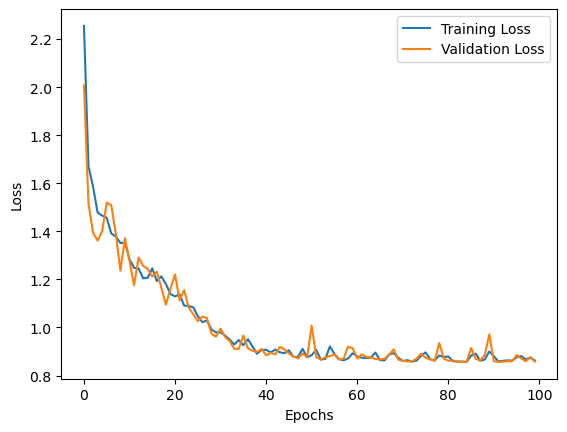

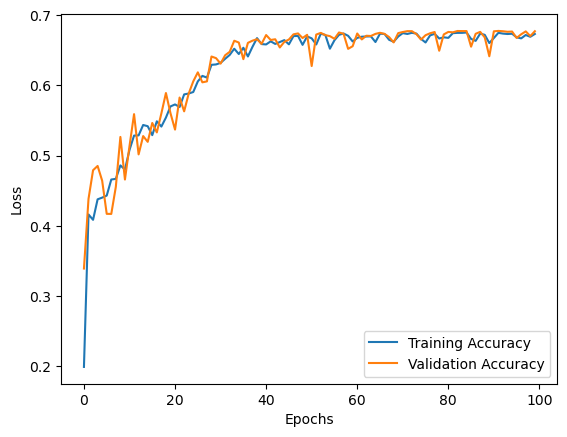

In [205]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
"""
Beta1 value of .99 seem to be desire pick slight improvments to fluctuations 
"""

### Beta2

In [206]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.999)) # adjust hyperpramater 0.99 -> 0.999
criterion = nn.CrossEntropyLoss()


In [207]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.4150, Training Accuracy: 0.4516
Epoch 10/100, Validation Loss: 1.4045, Validation Accuracy: 0.4636
Epoch 20/100, Training Loss: 1.2088, Training Accuracy: 0.5410
Epoch 20/100, Validation Loss: 1.2086, Validation Accuracy: 0.5443
Epoch 30/100, Training Loss: 1.0909, Training Accuracy: 0.5904
Epoch 30/100, Validation Loss: 1.0693, Validation Accuracy: 0.5943
Epoch 40/100, Training Loss: 0.9489, Training Accuracy: 0.6432
Epoch 40/100, Validation Loss: 0.9466, Validation Accuracy: 0.6464
Epoch 50/100, Training Loss: 0.9059, Training Accuracy: 0.6586
Epoch 50/100, Validation Loss: 0.9005, Validation Accuracy: 0.6622
Epoch 60/100, Training Loss: 0.8784, Training Accuracy: 0.6689
Epoch 60/100, Validation Loss: 0.8782, Validation Accuracy: 0.6710
Epoch 70/100, Training Loss: 0.8766, Training Accuracy: 0.6687
Epoch 70/100, Validation Loss: 0.8838, Validation Accuracy: 0.6674
Epoch 80/100, Training Loss: 0.8676, Training Accuracy: 0.6714
Epoch 80/100, Validation Lo

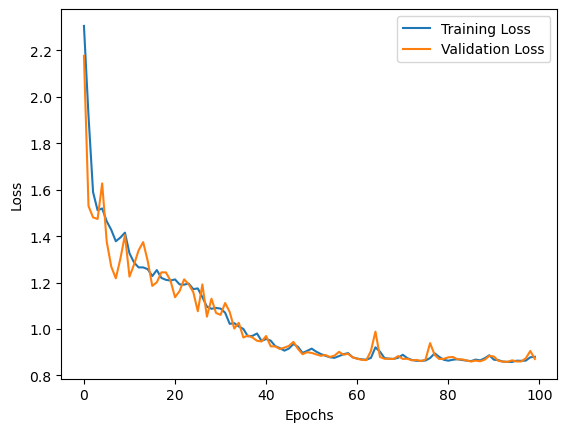

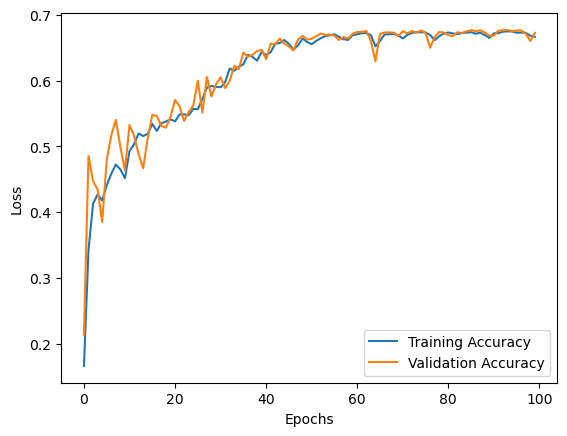

In [208]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [215]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.9999)) # adjust hyperpramater 0.999 -> 0.9999
criterion = nn.CrossEntropyLoss()


In [216]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2733, Training Accuracy: 0.5159
Epoch 10/100, Validation Loss: 1.2632, Validation Accuracy: 0.5173
Epoch 20/100, Training Loss: 1.1742, Training Accuracy: 0.5556
Epoch 20/100, Validation Loss: 1.1707, Validation Accuracy: 0.5566
Epoch 30/100, Training Loss: 1.0680, Training Accuracy: 0.5940
Epoch 30/100, Validation Loss: 1.0456, Validation Accuracy: 0.6064
Epoch 40/100, Training Loss: 0.9674, Training Accuracy: 0.6338
Epoch 40/100, Validation Loss: 0.9479, Validation Accuracy: 0.6463
Epoch 50/100, Training Loss: 0.8689, Training Accuracy: 0.6729
Epoch 50/100, Validation Loss: 0.8667, Validation Accuracy: 0.6751
Epoch 60/100, Training Loss: 0.8907, Training Accuracy: 0.6638
Epoch 60/100, Validation Loss: 0.9077, Validation Accuracy: 0.6583
Epoch 70/100, Training Loss: 0.8586, Training Accuracy: 0.6750
Epoch 70/100, Validation Loss: 0.8578, Validation Accuracy: 0.6774
Epoch 80/100, Training Loss: 0.8561, Training Accuracy: 0.6754
Epoch 80/100, Validation Lo

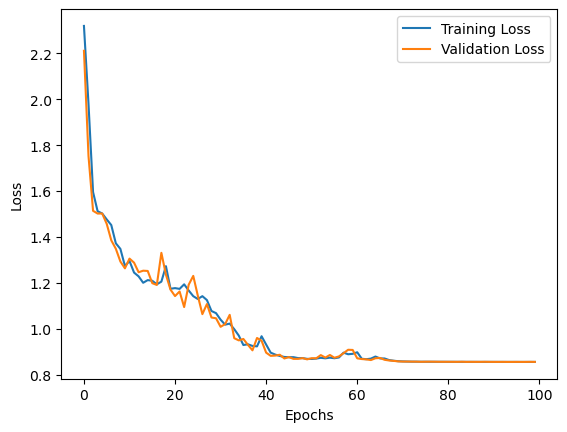

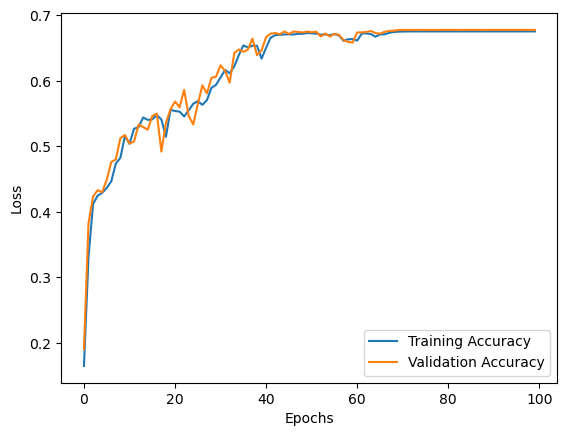

In [217]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [212]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 # adjust hyperpramater 0.01 -> 0.001
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995)) # adjust hyperpramater 0.9999 -> 0.995
criterion = nn.CrossEntropyLoss()


In [213]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3016, Training Accuracy: 0.4986
Epoch 10/100, Validation Loss: 1.2794, Validation Accuracy: 0.4999
Epoch 20/100, Training Loss: 1.2274, Training Accuracy: 0.5288
Epoch 20/100, Validation Loss: 1.1661, Validation Accuracy: 0.5573
Epoch 30/100, Training Loss: 1.1375, Training Accuracy: 0.5674
Epoch 30/100, Validation Loss: 1.2285, Validation Accuracy: 0.5354
Epoch 40/100, Training Loss: 0.9393, Training Accuracy: 0.6487
Epoch 40/100, Validation Loss: 0.9266, Validation Accuracy: 0.6574
Epoch 50/100, Training Loss: 0.8909, Training Accuracy: 0.6639
Epoch 50/100, Validation Loss: 0.8881, Validation Accuracy: 0.6676
Epoch 60/100, Training Loss: 0.8756, Training Accuracy: 0.6686
Epoch 60/100, Validation Loss: 0.8897, Validation Accuracy: 0.6673
Epoch 70/100, Training Loss: 0.8693, Training Accuracy: 0.6711
Epoch 70/100, Validation Loss: 0.8672, Validation Accuracy: 0.6743
Epoch 80/100, Training Loss: 0.8627, Training Accuracy: 0.6730
Epoch 80/100, Validation Lo

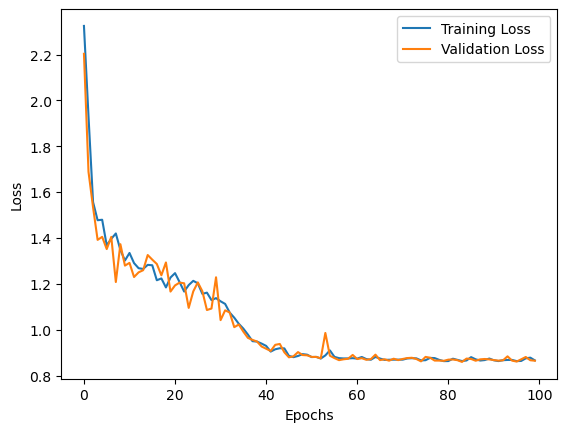

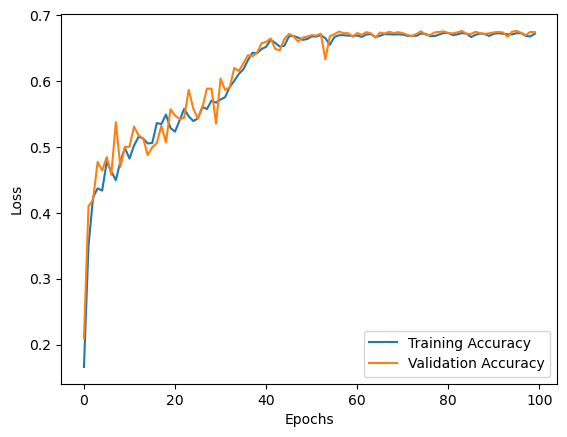

In [214]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [616]:
"""
Stability with the betas1 .99 and betas2 .995 seem slightly improve with these pramaters 
"""

'\nStability with the betas1 .99 and betas2 .995 seem slightly improve with these pramaters \n'

## 2a.3 Model Experimentation hyperparameters: Adjust batch sizes

In [219]:
# DataLoader
batch_size = 32
epoch = 100
learning_rate = 0.001 # adjust hyperpramater 0.01 -> 0.001
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [220]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2172, Training Accuracy: 0.5341
Epoch 10/100, Validation Loss: 1.2812, Validation Accuracy: 0.5077
Epoch 20/100, Training Loss: 1.0869, Training Accuracy: 0.5858
Epoch 20/100, Validation Loss: 1.0297, Validation Accuracy: 0.6117
Epoch 30/100, Training Loss: 0.9102, Training Accuracy: 0.6575
Epoch 30/100, Validation Loss: 0.8912, Validation Accuracy: 0.6658
Epoch 40/100, Training Loss: 0.8848, Training Accuracy: 0.6654
Epoch 40/100, Validation Loss: 0.8739, Validation Accuracy: 0.6721
Epoch 50/100, Training Loss: 0.8794, Training Accuracy: 0.6674
Epoch 50/100, Validation Loss: 0.8864, Validation Accuracy: 0.6674
Epoch 60/100, Training Loss: 0.8708, Training Accuracy: 0.6704
Epoch 60/100, Validation Loss: 0.8724, Validation Accuracy: 0.6719
Epoch 70/100, Training Loss: 0.8769, Training Accuracy: 0.6677
Epoch 70/100, Validation Loss: 0.8640, Validation Accuracy: 0.6754
Epoch 80/100, Training Loss: 0.8694, Training Accuracy: 0.6707
Epoch 80/100, Validation Lo

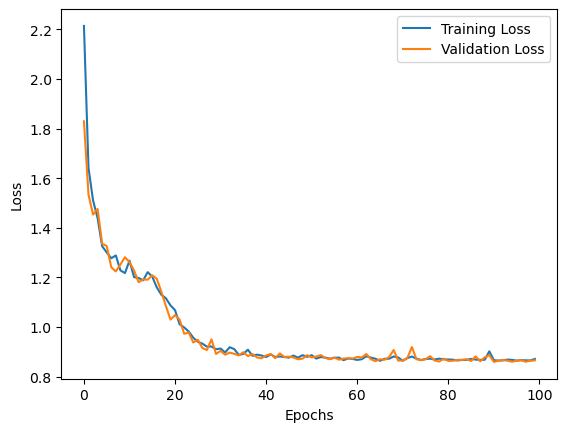

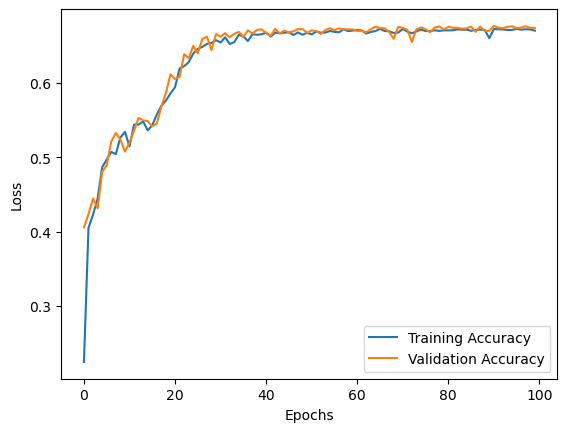

In [221]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [281]:
# DataLoader
batch_size = 16
epoch = 100
learning_rate = 0.001 # adjust hyperpramater 0.01 -> 0.001
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [282]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.2230, Training Accuracy: 0.5342
Epoch 10/100, Validation Loss: 1.2251, Validation Accuracy: 0.5357
Epoch 20/100, Training Loss: 1.0130, Training Accuracy: 0.6174
Epoch 20/100, Validation Loss: 1.0351, Validation Accuracy: 0.6061
Epoch 30/100, Training Loss: 0.9014, Training Accuracy: 0.6604
Epoch 30/100, Validation Loss: 0.8963, Validation Accuracy: 0.6610
Epoch 40/100, Training Loss: 0.8881, Training Accuracy: 0.6646
Epoch 40/100, Validation Loss: 0.9134, Validation Accuracy: 0.6562
Epoch 50/100, Training Loss: 0.8758, Training Accuracy: 0.6693
Epoch 50/100, Validation Loss: 0.8795, Validation Accuracy: 0.6660
Epoch 60/100, Training Loss: 0.8760, Training Accuracy: 0.6690
Epoch 60/100, Validation Loss: 0.8691, Validation Accuracy: 0.6702
Epoch 70/100, Training Loss: 0.8723, Training Accuracy: 0.6702
Epoch 70/100, Validation Loss: 0.8682, Validation Accuracy: 0.6712
Epoch 80/100, Training Loss: 0.8693, Training Accuracy: 0.6714
Epoch 80/100, Validation Lo

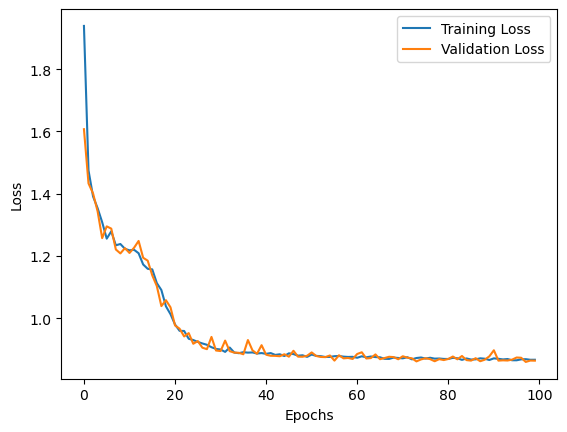

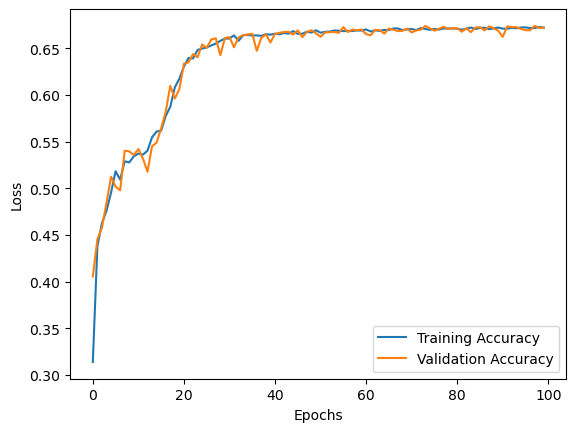

In [283]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [285]:
# DataLoader
batch_size = 128
epoch = 100
learning_rate = 0.001 # adjust hyperpramater 0.01 -> 0.001
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.0).to(device)
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.00).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [286]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3954, Training Accuracy: 0.4759
Epoch 10/100, Validation Loss: 1.4307, Validation Accuracy: 0.4641
Epoch 20/100, Training Loss: 1.3110, Training Accuracy: 0.4940
Epoch 20/100, Validation Loss: 1.3284, Validation Accuracy: 0.4858
Epoch 30/100, Training Loss: 1.1936, Training Accuracy: 0.5444
Epoch 30/100, Validation Loss: 1.0538, Validation Accuracy: 0.6041
Epoch 40/100, Training Loss: 1.2022, Training Accuracy: 0.5440
Epoch 40/100, Validation Loss: 1.1804, Validation Accuracy: 0.5531
Epoch 50/100, Training Loss: 1.1813, Training Accuracy: 0.5514
Epoch 50/100, Validation Loss: 1.2588, Validation Accuracy: 0.5209
Epoch 60/100, Training Loss: 1.1209, Training Accuracy: 0.5725
Epoch 60/100, Validation Loss: 1.2043, Validation Accuracy: 0.5384
Epoch 70/100, Training Loss: 1.0495, Training Accuracy: 0.6013
Epoch 70/100, Validation Loss: 1.0051, Validation Accuracy: 0.6124
Epoch 80/100, Training Loss: 0.9849, Training Accuracy: 0.6288
Epoch 80/100, Validation Lo

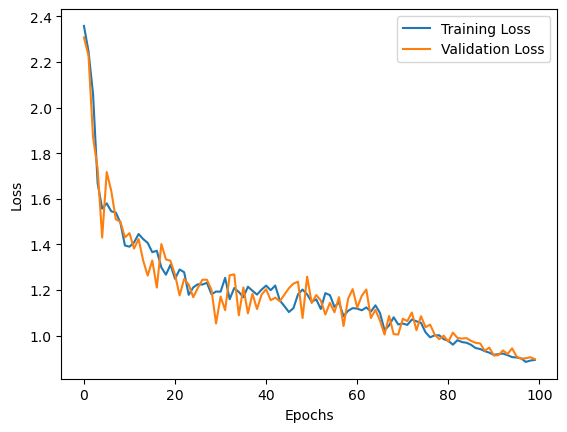

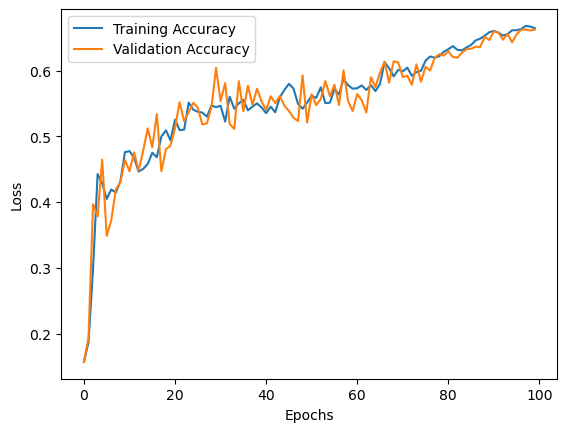

In [287]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
""" 
Sticking with batch size 64 has proven to be most stable and reliable for consistent results.
"""

## 2a.4 Model Experimentation hyperparameters: Adjust dropouts

In [306]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)

    def forward(self, x):
        _, (hidden, cell) = self.rnn(x)
        return hidden, cell
   

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)  # create a dropout layer


    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        output = self.dropout(output)  # Apply dropout
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

In [307]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.5).to(device) # adjust hyperpramater 0.0 -> 0.5
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.5).to(device) # adjust hyperpramater 0.0 -> 0.05
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995), weight_decay=1e-5) # testing out weight decay
criterion = nn.CrossEntropyLoss()


In [308]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3760, Training Accuracy: 0.4666
Epoch 10/100, Validation Loss: 1.2725, Validation Accuracy: 0.5050
Epoch 20/100, Training Loss: 1.2742, Training Accuracy: 0.5116
Epoch 20/100, Validation Loss: 1.2377, Validation Accuracy: 0.5286
Epoch 30/100, Training Loss: 1.2548, Training Accuracy: 0.5218
Epoch 30/100, Validation Loss: 1.1458, Validation Accuracy: 0.5630
Epoch 40/100, Training Loss: 1.1491, Training Accuracy: 0.5616
Epoch 40/100, Validation Loss: 1.1289, Validation Accuracy: 0.5708
Epoch 50/100, Training Loss: 1.0475, Training Accuracy: 0.5977
Epoch 50/100, Validation Loss: 0.9758, Validation Accuracy: 0.6416
Epoch 60/100, Training Loss: 0.9879, Training Accuracy: 0.6238
Epoch 60/100, Validation Loss: 0.9083, Validation Accuracy: 0.6639
Epoch 70/100, Training Loss: 0.9486, Training Accuracy: 0.6403
Epoch 70/100, Validation Loss: 0.8856, Validation Accuracy: 0.6690
Epoch 80/100, Training Loss: 0.9229, Training Accuracy: 0.6518
Epoch 80/100, Validation Lo

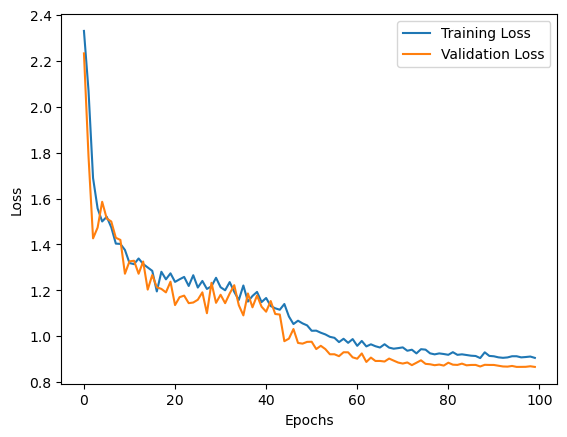

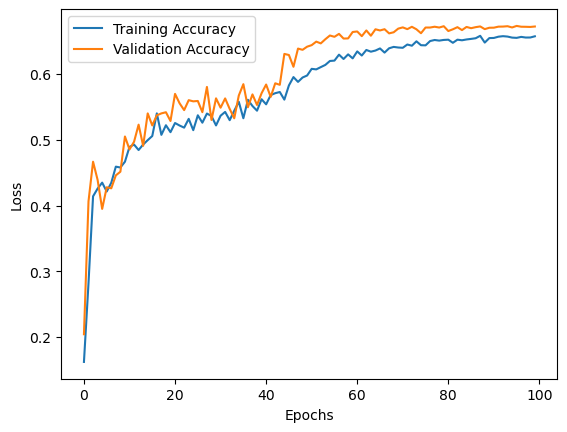

In [309]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [291]:
# DataLoader
batch_size = 64
num_epochs = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.1).to(device) # adjust hyperpramater 0.0 -> 0.1
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.1).to(device) # adjust hyperpramater 0.0 -> 0.1
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [292]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3714, Training Accuracy: 0.4699
Epoch 10/100, Validation Loss: 1.3863, Validation Accuracy: 0.4724
Epoch 20/100, Training Loss: 1.2207, Training Accuracy: 0.5327
Epoch 20/100, Validation Loss: 1.2171, Validation Accuracy: 0.5380
Epoch 30/100, Training Loss: 1.2039, Training Accuracy: 0.5419
Epoch 30/100, Validation Loss: 1.1408, Validation Accuracy: 0.5683
Epoch 40/100, Training Loss: 1.0765, Training Accuracy: 0.5897
Epoch 40/100, Validation Loss: 1.0082, Validation Accuracy: 0.6198
Epoch 50/100, Training Loss: 0.9357, Training Accuracy: 0.6496
Epoch 50/100, Validation Loss: 0.9195, Validation Accuracy: 0.6602
Epoch 60/100, Training Loss: 0.9015, Training Accuracy: 0.6600
Epoch 60/100, Validation Loss: 0.8735, Validation Accuracy: 0.6713
Epoch 70/100, Training Loss: 0.8896, Training Accuracy: 0.6646
Epoch 70/100, Validation Loss: 0.8866, Validation Accuracy: 0.6638
Epoch 80/100, Training Loss: 0.8788, Training Accuracy: 0.6686
Epoch 80/100, Validation Lo

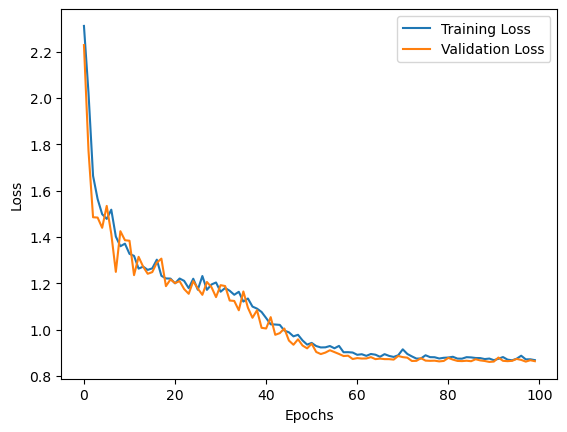

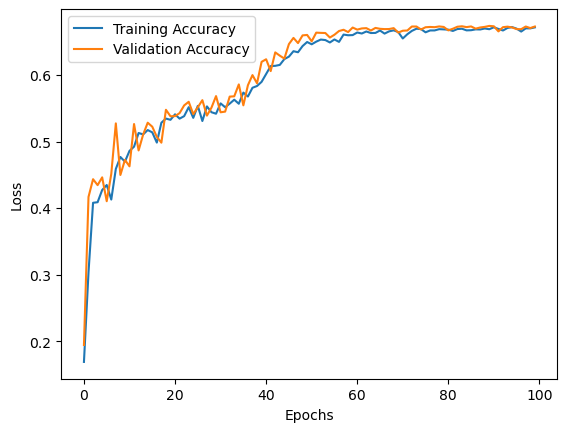

In [293]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [310]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.2).to(device) # adjust hyperpramater 0.0 -> 0.1
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.2).to(device) # adjust hyperpramater 0.0 -> 0.1
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [311]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.4072, Training Accuracy: 0.4563
Epoch 10/100, Validation Loss: 1.3422, Validation Accuracy: 0.4821
Epoch 20/100, Training Loss: 1.2552, Training Accuracy: 0.5224
Epoch 20/100, Validation Loss: 1.2524, Validation Accuracy: 0.5248
Epoch 30/100, Training Loss: 1.0963, Training Accuracy: 0.5847
Epoch 30/100, Validation Loss: 1.1001, Validation Accuracy: 0.5888
Epoch 40/100, Training Loss: 0.9925, Training Accuracy: 0.6229
Epoch 40/100, Validation Loss: 0.9901, Validation Accuracy: 0.6290
Epoch 50/100, Training Loss: 0.9285, Training Accuracy: 0.6495
Epoch 50/100, Validation Loss: 0.8952, Validation Accuracy: 0.6649
Epoch 60/100, Training Loss: 0.9102, Training Accuracy: 0.6562
Epoch 60/100, Validation Loss: 0.8897, Validation Accuracy: 0.6623
Epoch 70/100, Training Loss: 0.9117, Training Accuracy: 0.6564
Epoch 70/100, Validation Loss: 0.8790, Validation Accuracy: 0.6683
Epoch 80/100, Training Loss: 0.8875, Training Accuracy: 0.6646
Epoch 80/100, Validation Lo

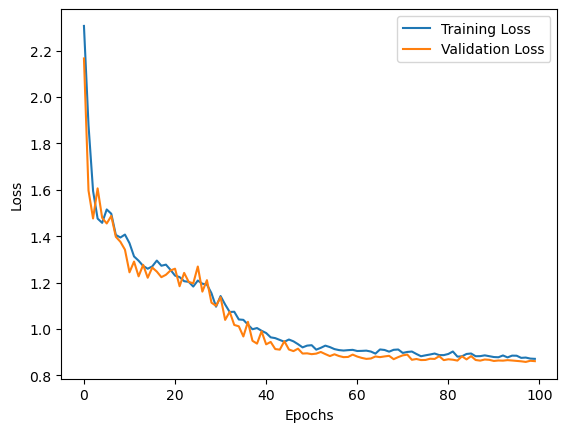

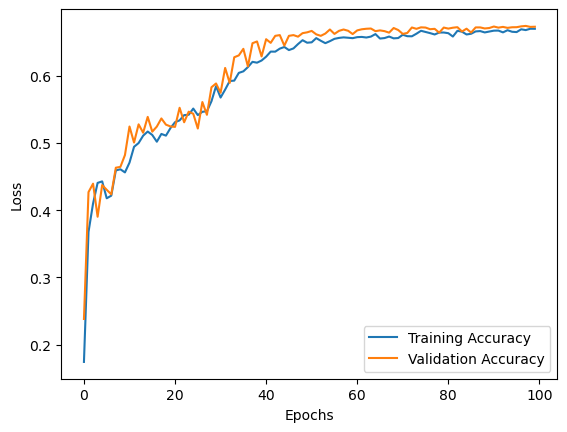

In [312]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [313]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) # adjust hyperpramater 0.0 -> 0.05
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device) # adjust hyperpramater 0.0 -> 0.05
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [314]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.3090, Training Accuracy: 0.4950
Epoch 10/100, Validation Loss: 1.2998, Validation Accuracy: 0.5018
Epoch 20/100, Training Loss: 1.2209, Training Accuracy: 0.5341
Epoch 20/100, Validation Loss: 1.1909, Validation Accuracy: 0.5448
Epoch 30/100, Training Loss: 1.1512, Training Accuracy: 0.5615
Epoch 30/100, Validation Loss: 1.0988, Validation Accuracy: 0.5811
Epoch 40/100, Training Loss: 1.1157, Training Accuracy: 0.5733
Epoch 40/100, Validation Loss: 1.0770, Validation Accuracy: 0.5860
Epoch 50/100, Training Loss: 0.9348, Training Accuracy: 0.6468
Epoch 50/100, Validation Loss: 0.9354, Validation Accuracy: 0.6466
Epoch 60/100, Training Loss: 0.8839, Training Accuracy: 0.6669
Epoch 60/100, Validation Loss: 0.8764, Validation Accuracy: 0.6687
Epoch 70/100, Training Loss: 0.8812, Training Accuracy: 0.6669
Epoch 70/100, Validation Loss: 0.8796, Validation Accuracy: 0.6676
Epoch 80/100, Training Loss: 0.8718, Training Accuracy: 0.6700
Epoch 80/100, Validation Lo

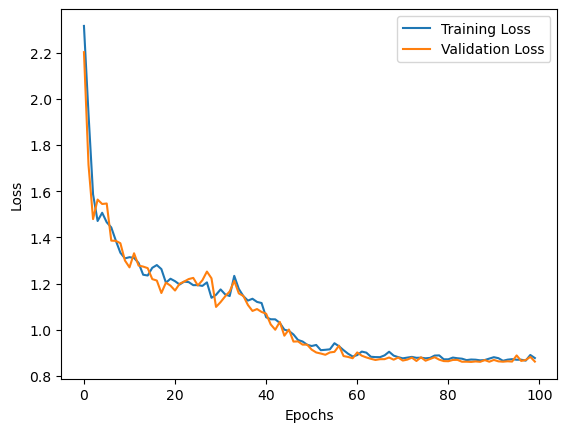

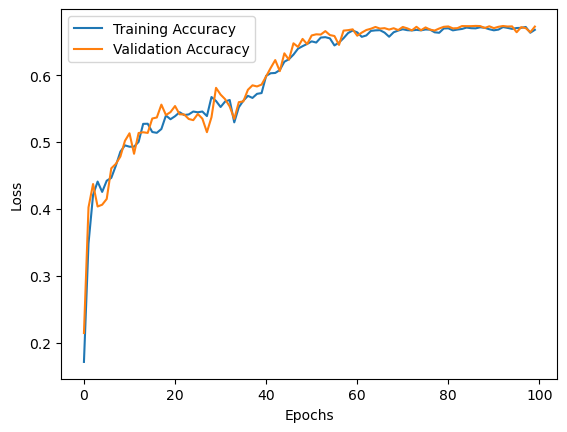

In [315]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# dropout 0.05 seem to have  highest and most stable accuracy, and the validation loss  thus, keeping it.

## 2a.5 Model Experimentation hyperparameters: Adjust activation

# BEST MODEL 

In [415]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)

    def forward(self, x):
        _, (hidden, cell) = self.rnn(x)
        return hidden, cell
   

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)  # create a dropout layer
        self.relu = nn.ReLU() # added activation relu function in Decoder


    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        output = self.dropout(output)  # Apply dropout
        prediction = self.relu(self.fc(output.squeeze(1)))
        return prediction, hidden, cell

In [317]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) 
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [318]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.4782, Training Accuracy: 0.4548
Epoch 10/100, Validation Loss: 1.3918, Validation Accuracy: 0.4847
Epoch 20/100, Training Loss: 1.2438, Training Accuracy: 0.5306
Epoch 20/100, Validation Loss: 1.1795, Validation Accuracy: 0.5549
Epoch 30/100, Training Loss: 1.2099, Training Accuracy: 0.5412
Epoch 30/100, Validation Loss: 1.1765, Validation Accuracy: 0.5522
Epoch 40/100, Training Loss: 1.1738, Training Accuracy: 0.5555
Epoch 40/100, Validation Loss: 1.1008, Validation Accuracy: 0.5800
Epoch 50/100, Training Loss: 1.0977, Training Accuracy: 0.5830
Epoch 50/100, Validation Loss: 1.0804, Validation Accuracy: 0.5874
Epoch 60/100, Training Loss: 0.9841, Training Accuracy: 0.6293
Epoch 60/100, Validation Loss: 0.9915, Validation Accuracy: 0.6303
Epoch 70/100, Training Loss: 0.9052, Training Accuracy: 0.6604
Epoch 70/100, Validation Loss: 0.8998, Validation Accuracy: 0.6678
Epoch 80/100, Training Loss: 0.8826, Training Accuracy: 0.6671
Epoch 80/100, Validation Lo

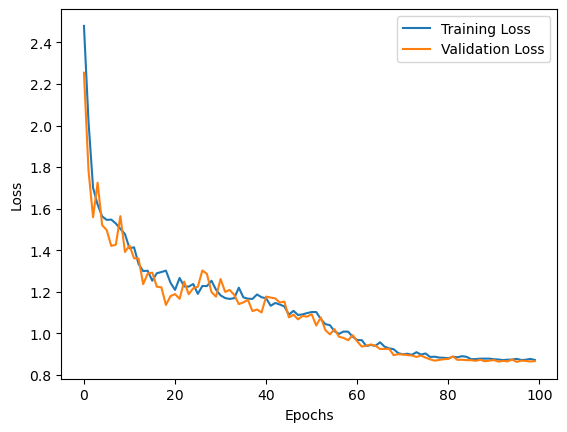

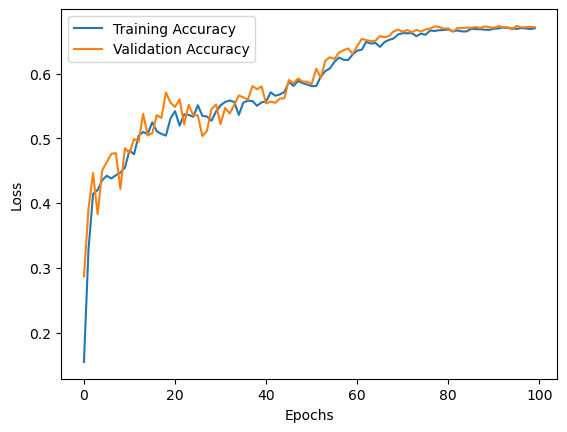

In [319]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [320]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) 
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [321]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)

    def forward(self, x):
        _, (hidden, cell) = self.rnn(x)
        return hidden, cell
   

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)  # create a dropout layer
        self.relu = nn.LeakyReLU() # added activation relu function in Decoder


    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        output = self.dropout(output)  # Apply dropout
        prediction = self.relu(self.fc(output.squeeze(1)))
        return prediction, hidden, cell

In [322]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.5011, Training Accuracy: 0.4526
Epoch 10/100, Validation Loss: 1.5505, Validation Accuracy: 0.4350
Epoch 20/100, Training Loss: 1.3047, Training Accuracy: 0.5203
Epoch 20/100, Validation Loss: 1.4020, Validation Accuracy: 0.4871
Epoch 30/100, Training Loss: 1.2665, Training Accuracy: 0.5279
Epoch 30/100, Validation Loss: 1.1685, Validation Accuracy: 0.5610
Epoch 40/100, Training Loss: 1.2149, Training Accuracy: 0.5427
Epoch 40/100, Validation Loss: 1.2083, Validation Accuracy: 0.5393
Epoch 50/100, Training Loss: 1.1241, Training Accuracy: 0.5741
Epoch 50/100, Validation Loss: 1.1592, Validation Accuracy: 0.5664
Epoch 60/100, Training Loss: 0.9614, Training Accuracy: 0.6422
Epoch 60/100, Validation Loss: 0.9350, Validation Accuracy: 0.6558
Epoch 70/100, Training Loss: 0.8985, Training Accuracy: 0.6631
Epoch 70/100, Validation Loss: 0.8921, Validation Accuracy: 0.6671
Epoch 80/100, Training Loss: 0.8925, Training Accuracy: 0.6636
Epoch 80/100, Validation Lo

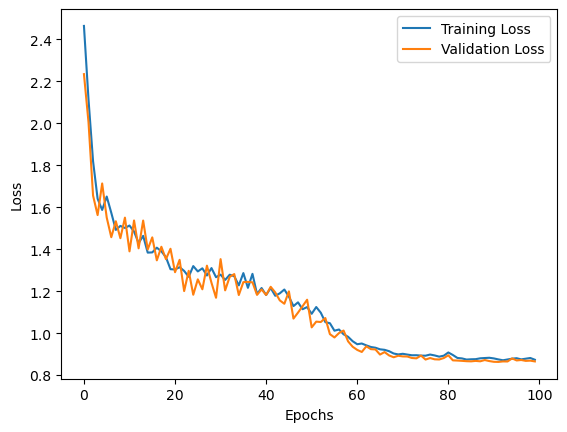

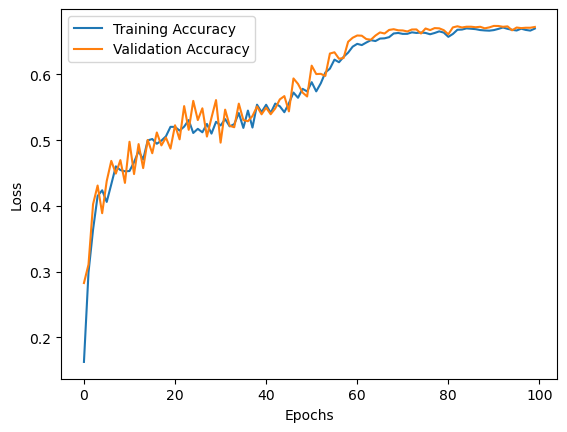

In [323]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [325]:
# Keep the reLU action due to it stable improvements in both training and validation loss

In [418]:
# DataLoader
batch_size = 64
epoch = 100
learning_rate = 0.001 
encoder = Encoder(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, p=0.05).to(device) 
decoder = Decoder(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers, p=0.05).to(device)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.995))
criterion = nn.CrossEntropyLoss()


In [419]:
tr_acc, tr_loss, val_acc, val_loss = train_model(train_dataset, val_dataset, test_dataset, batch_size, model, optimizer, criterion, device, epoch)

Epoch 10/100, Training Loss: 1.4382, Training Accuracy: 0.4815
Epoch 10/100, Validation Loss: 1.4606, Validation Accuracy: 0.4771
Epoch 20/100, Training Loss: 1.3037, Training Accuracy: 0.5087
Epoch 20/100, Validation Loss: 1.3015, Validation Accuracy: 0.5117
Epoch 30/100, Training Loss: 1.2765, Training Accuracy: 0.5171
Epoch 30/100, Validation Loss: 1.2030, Validation Accuracy: 0.5450
Epoch 40/100, Training Loss: 1.3302, Training Accuracy: 0.4994
Epoch 40/100, Validation Loss: 1.3113, Validation Accuracy: 0.5081
Epoch 50/100, Training Loss: 1.2961, Training Accuracy: 0.5125
Epoch 50/100, Validation Loss: 1.2663, Validation Accuracy: 0.5227
Epoch 60/100, Training Loss: 1.2294, Training Accuracy: 0.5375
Epoch 60/100, Validation Loss: 1.2160, Validation Accuracy: 0.5440
Epoch 70/100, Training Loss: 1.2174, Training Accuracy: 0.5385
Epoch 70/100, Validation Loss: 1.1990, Validation Accuracy: 0.5437
Epoch 80/100, Training Loss: 1.1159, Training Accuracy: 0.5732
Epoch 80/100, Validation Lo

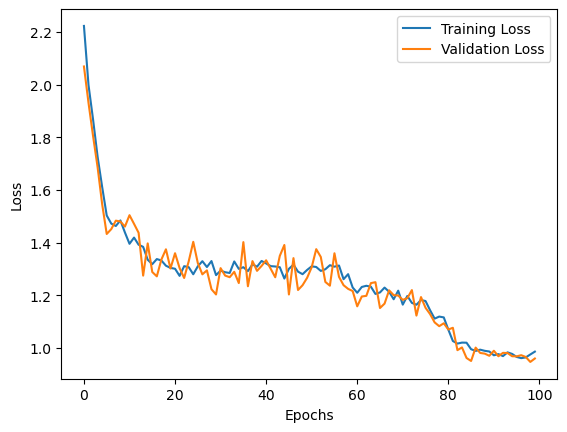

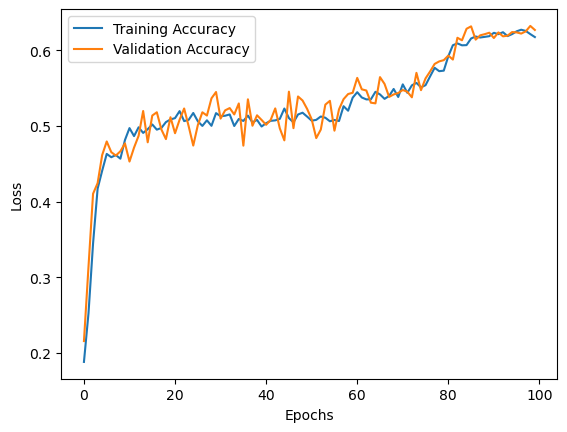

In [420]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [614]:
# keeping ReLu actiavtion